In [0]:
import pandas as pd

In [0]:
import numpy as np

In [0]:
import matplotlib.pyplot as plt

In [0]:
import keras

Using TensorFlow backend.


# Предобработка данных

In [0]:
def train_test_split(X, y, test_size=0.15):   #Функция делит выборку на обучающую и тестовую 
    train_len = int(X.shape[0]*test_size)
    X_train = X[:-train_len]
    X_test = X[-train_len:]
    y_train = y[:-train_len]
    y_test = y[-train_len:]
    return (X_train, X_test, y_train, y_test)

In [0]:
data = pd.read_csv('^DJI (1).csv')
close_price_pct = data['Adj Close'].pct_change().dropna().tolist()
close_price = data['Adj Close'].tolist() #выбираю только колонку Adj Close
num_days=10

In [0]:
X_pct=[]
y_pct=[]
for day in range(len(close_price_pct)-num_days): #Создаю обучающий датасет по формату
    X_pct.append(close_price_pct[day:day+num_days]) #один объект X - десять значений роста цены в процентах отн. пред. дня
    y_pct.append(close_price_pct[day+num_days]) #один объект y - рост в день после этих десяти
X_pct=np.array(X_pct)
y_pct=np.array(y_pct)

In [0]:
X=[]
y=[]
for day in range(len(close_price)-num_days): #Создаю обучающий датасет по формату
    X.append(close_price[day:day+num_days]) #один объект X - десять значений цены
    y.append(close_price[day+num_days]) #один объект y - цена в день после этих десяти
X=np.array(X)
y=np.array(y)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15) #разделяю датасет на обучающий и валидационный
X_train_pct, X_test_pct, y_train_pct, y_test_pct = train_test_split(X_pct, y_pct, test_size=0.15) #разделяю датасет на обучающий и валидационный

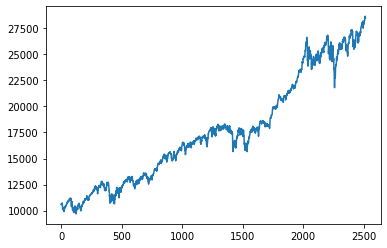

In [0]:
plt.plot(close_price)

# MLP

### MLP isbig=True - сеть с ~4000 параметров
### MLP isbig=False - сеть с ~1500 параметров

In [0]:
def create_mlp(isbig = False):
    model_mlp = keras.models.Sequential()
    
    if isbig:
        model_mlp.add(keras.layers.Dense(64, input_dim=10, activity_regularizer=keras.regularizers.l1(0.01))) #полносвязный слой с 64 нейронами и l2 регуляризация на их веса
        model_mlp.add(keras.layers.BatchNormalization()) #регуляризация нужна для борьбы с переобучением
        model_mlp.add(keras.layers.LeakyReLU()) #функция активации
        model_mlp.add(keras.layers.Dropout(0.2))
        model_mlp.add(keras.layers.Dense(32,activity_regularizer=keras.regularizers.l1(0.01))) #полносвязный слой с 64 нейронами и l2 регуляризация на их веса
        model_mlp.add(keras.layers.BatchNormalization()) #регуляризация нужна для борьбы с переобучением
        model_mlp.add(keras.layers.LeakyReLU()) #функция активации
    else:
        model_mlp.add(keras.layers.Dense(32,input_dim=10,activity_regularizer=keras.regularizers.l1(0.01))) #полносвязный слой с 64 нейронами и l2 регуляризация на их веса
        model_mlp.add(keras.layers.BatchNormalization()) #регуляризация нужна для борьбы с переобучением
        model_mlp.add(keras.layers.LeakyReLU()) #функция активации
        
    model_mlp.add(keras.layers.Dense(32,activity_regularizer=keras.regularizers.l1(0.01))) #полносвязный слой с 16 нейронами и l2 регуляризация на их веса
    model_mlp.add(keras.layers.BatchNormalization()) #слой, автоматически нормализующий данные внутри батча (нормализация для нейронки -всегда хорошо)
    model_mlp.add(keras.layers.LeakyReLU())#функция активации
    model_mlp.add(keras.layers.Dense(1))
    model_mlp.add(keras.layers.Activation('linear'))
    
    opt = keras.optimizers.Adam(learning_rate = 0.001)
    model_mlp.compile(optimizer=opt,                
              loss='mse',
              metrics=['mse'])
    
    return model_mlp

In [0]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.0001, verbose=1)
#строчкой выше - коллбэк, автоматически уменьшающий learning rate, если тот не изменяется в течении 5 эпох lr' = lr*factor

### MLP big на сырых показателях цены

In [0]:
model_mlp_big=create_mlp(isbig = True)
history_mlp = model_mlp_big.fit(X_train, y_train, 
          epochs = 25, 
          batch_size = 128, 
          verbose=1, 
          validation_data=(X_test,y_test),
          shuffle=False,
          callbacks=[reduce_lr])

Train on 2130 samples, validate on 375 samples
Epoch 1/25
2130/2130 [==============================] - 1s 376us/step - loss: 277590364.6648 - mse: 277189440.0000 - val_loss: 677732525.7387 - val_mse: 677229568.0000
Epoch 2/25
2130/2130 [==============================] - 0s 21us/step - loss: 277418488.3080 - mse: 277179744.0000 - val_loss: 678190010.0267 - val_mse: 677897984.0000
Epoch 3/25
2130/2130 [==============================] - 0s 21us/step - loss: 277308781.7915 - mse: 277170752.0000 - val_loss: 678883779.0720 - val_mse: 678724736.0000
Epoch 4/25
2130/2130 [==============================] - 0s 24us/step - loss: 277234171.4930 - mse: 277162272.0000 - val_loss: 678862214.9973 - val_mse: 678781376.0000
Epoch 5/25
2130/2130 [==============================] - 0s 21us/step - loss: 277189258.6967 - mse: 277153216.0000 - val_loss: 678814645.9307 - val_mse: 678773760.0000
Epoch 6/25
2130/2130 [==============================] - 0s 23us/step - loss: 277161786.3512 - mse: 277144160.0000 - v

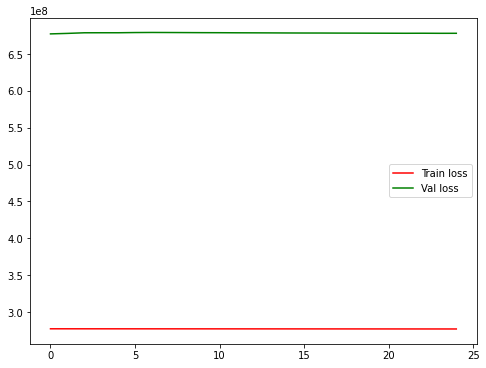

In [0]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.plot(history_mlp.history['mse'], color="red", label="Train loss")
ax.plot(history_mlp.history['val_mse'], color="green", label="Val loss")
ax.legend()

### Итог:
#### Loss не падает, а mse очень велико

### MLP big на процентах увеличения цены

In [0]:
model_mlp_pct_big = create_mlp(isbig = True)
history_mlp_pct_big  = model_mlp_pct_big.fit(X_train_pct, y_train_pct, 
          epochs = 250, 
          batch_size = 128, 
          verbose=1, 
          validation_data=(X_test_pct,y_test_pct),
          shuffle=False,
          callbacks=[reduce_lr])

Train on 2129 samples, validate on 375 samples
Epoch 1/250
2129/2129 [==============================] - 1s 240us/step - loss: 22.8510 - mse: 0.5826 - val_loss: 1.5106 - val_mse: 0.0021
Epoch 2/250
2129/2129 [==============================] - 0s 22us/step - loss: 17.5186 - mse: 0.3999 - val_loss: 2.3287 - val_mse: 0.0064
Epoch 3/250
2129/2129 [==============================] - 0s 21us/step - loss: 14.0748 - mse: 0.2986 - val_loss: 2.6855 - val_mse: 0.0078
Epoch 4/250
2129/2129 [==============================] - 0s 21us/step - loss: 11.6967 - mse: 0.2321 - val_loss: 2.7343 - val_mse: 0.0082
Epoch 5/250
2129/2129 [==============================] - 0s 21us/step - loss: 9.9260 - mse: 0.1675 - val_loss: 2.6755 - val_mse: 0.0082
Epoch 6/250
2129/2129 [==============================] - 0s 21us/step - loss: 8.7532 - mse: 0.1523 - val_loss: 2.5367 - val_mse: 0.0078

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
Epoch 7/250
2129/2129 [============================

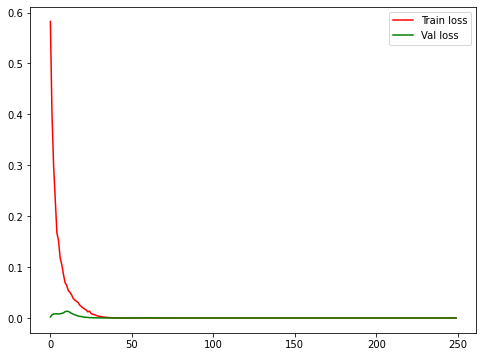

In [0]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.plot(history_mlp_pct_big.history['mse'], color="red", label="Train loss")
ax.plot(history_mlp_pct_big.history['val_mse'], color="green", label="Val loss")
ax.legend()

In [0]:
X_test_pct.shape

(375, 10)

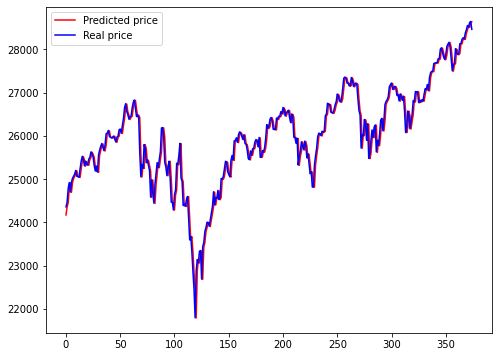

In [0]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.plot((X_test[-375:,-1]*(np.hstack(1+model_mlp_pct_big.predict(X_test_pct[-375:])))), color="red", label="Predicted price")
ax.plot(close_price[-375:], color="blue", label="Real price")
ax.legend()

In [0]:
def accuracy(arr1, arr2):
    t=0
    for i in range(len(arr1)-1):
        if((arr1[i+1]-arr1[i]>0) & (arr2[i+1]-arr2[i]>0)):
            t+=1
        if((arr1[i+1]-arr1[i]<0) & (arr2[i+1]-arr2[i]<0)): 
            t+=1
    return t/len(arr1)
        

In [0]:
X_test_pct[:].shape

(375, 10)

In [0]:
accuracy(X_test[:,-1]*(np.hstack(1+model_mlp_pct_big.predict(X_test_pct[:]))),close_price[-375:])

0.496

In [0]:
(X_test[1:,-1]*(np.hstack(1+model_mlp_pct_big.predict(X_test_pct[:-1]))))-close_price[-374:]

array([-1.20009915e+02, -3.37462072e+02, -1.63129684e+02,  2.03473892e+02,
       -2.42221908e+02, -1.11865855e+02, -6.48204325e+01, -7.39994876e+01,
       -9.54955035e+01,  1.17541658e+02, -1.12926951e+01, -7.08751396e+00,
       -2.16482999e+02, -1.91570186e+02, -1.29668327e+02,  5.71503774e+01,
        1.26472450e+02, -1.28187354e+02,  6.20152460e+01, -1.16831141e+01,
       -1.53844736e+02, -5.66842243e+01, -1.44812963e+02,  2.64928585e+01,
        5.53986804e+01,  1.77181296e+02,  1.07809794e+02, -1.31402862e+02,
        1.19155986e+02, -4.13665460e+02, -1.28857162e+02, -1.06921423e+02,
       -8.32949199e+01,  7.06277826e+01,  5.53969012e+01, -1.51507873e+02,
       -2.78700014e+02, -3.22285104e+01, -7.77282365e+01,  1.19919173e+02,
        2.43889923e+00, -9.18915195e+00, -4.16478680e+01, -4.06714802e+01,
        6.19775126e+01,  4.16053060e+01, -1.33131957e+02, -4.88625825e+01,
       -1.65934279e+02, -2.72950443e+01,  7.48490195e+01, -2.03540354e+02,
       -1.77564295e+02, -

In [0]:
X_test[1:,-1].shape

(374,)

In [0]:
close_price[-375:]

[24356.740234,
 24456.480469,
 24776.589844,
 24919.660156,
 24700.449219,
 24924.890625,
 25019.410156,
 25064.359375,
 25119.890625,
 25199.289063,
 25064.5,
 25058.119141,
 25044.289063,
 25241.939453,
 25414.099609,
 25527.070313,
 25451.060547,
 25306.830078,
 25415.189453,
 25333.820313,
 25326.160156,
 25462.580078,
 25502.179688,
 25628.910156,
 25583.75,
 25509.230469,
 25313.140625,
 25187.699219,
 25299.919922,
 25162.410156,
 25558.730469,
 25669.320313,
 25758.689453,
 25822.289063,
 25733.599609,
 25656.980469,
 25790.349609,
 26049.640625,
 26064.019531,
 26124.570313,
 25986.919922,
 25964.820313,
 25952.480469,
 25974.990234,
 25995.869141,
 25916.539063,
 25857.070313,
 25971.060547,
 25998.919922,
 26145.990234,
 26154.669922,
 26062.119141,
 26246.960938,
 26405.759766,
 26656.980469,
 26743.5,
 26562.050781,
 26492.210938,
 26385.279297,
 26439.929688,
 26458.310547,
 26651.210938,
 26773.939453,
 26828.390625,
 26627.480469,
 26447.050781,
 26486.779297,
 26430.57

In [0]:
np.mean(keras.losses.mean_squared_error(X_test[:,-1]*(1+model_mlp_pct_big.predict(X_test_pct)), y_test))

53148.95

### MLP not big на процентах увеличения цены

In [0]:
model_mlp_pct_sm = create_mlp()
history_mlp_pct_sm = model_mlp_pct_sm.fit(X_train_pct, y_train_pct, 
          epochs = 25, 
          batch_size = 128, 
          verbose=1, 
          validation_data=(X_test_pct,y_test_pct),
          shuffle=False,
          callbacks=[reduce_lr])

Train on 2129 samples, validate on 375 samples
Epoch 1/25
2129/2129 [==============================] - 0s 155us/step - loss: 3.9704 - mse: 0.3928 - val_loss: 0.8105 - val_mse: 0.0021
Epoch 2/25
2129/2129 [==============================] - 0s 16us/step - loss: 2.9031 - mse: 0.1320 - val_loss: 1.0166 - val_mse: 0.0094
Epoch 3/25
2129/2129 [==============================] - 0s 16us/step - loss: 2.2653 - mse: 0.0717 - val_loss: 0.8956 - val_mse: 0.0177
Epoch 4/25
2129/2129 [==============================] - 0s 16us/step - loss: 1.8203 - mse: 0.0560 - val_loss: 0.7403 - val_mse: 0.0230
Epoch 5/25
2129/2129 [==============================] - 0s 16us/step - loss: 1.4824 - mse: 0.0475 - val_loss: 0.6085 - val_mse: 0.0253
Epoch 6/25
2129/2129 [==============================] - 0s 16us/step - loss: 1.2204 - mse: 0.0411 - val_loss: 0.4952 - val_mse: 0.0268
Epoch 7/25
2129/2129 [==============================] - 0s 16us/step - loss: 1.0165 - mse: 0.0348 - val_loss: 0.4078 - val_mse: 0.0278
Epoch 8

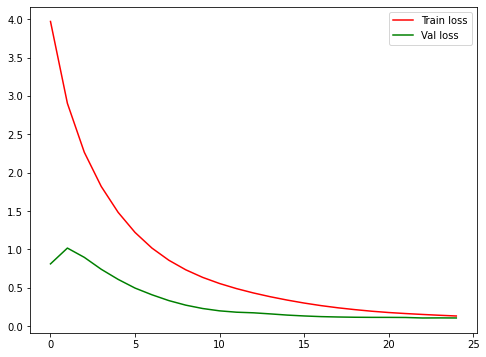

In [0]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.plot(history_mlp_pct_sm.history['loss'], color="red", label="Train loss")
ax.plot(history_mlp_pct_sm.history['val_loss'], color="green", label="Val loss")
ax.legend()

In [0]:
np.mean(keras.losses.mean_squared_error(X_train[:,-1]*(1+model_mlp_pct_sm.predict(X_train_pct)), y_train))

43593.438

# CNN

In [0]:
def create_cnn(isbig=False):
    model_cnn = keras.models.Sequential()
    if isbig:
        model_cnn.add(keras.layers.Conv1D(64,3,activation='relu'))
        model_cnn.add(keras.layers.AveragePooling1D(2,1))
        model_cnn.add(keras.layers.Dropout(0.2))
        model_cnn.add(keras.layers.Conv1D(128,2,activation='relu'))
        model_cnn.add(keras.layers.AveragePooling1D(2,1))
        model_cnn.add(keras.layers.Dropout(0.2))
    
    else:
        model_cnn.add(keras.layers.Conv1D(4,3,activation='relu'))
        model_cnn.add(keras.layers.AveragePooling1D(2,1))
        model_cnn.add(keras.layers.Dropout(0.2))
        model_cnn.add(keras.layers.Conv1D(16,2,activation='relu'))
        model_cnn.add(keras.layers.AveragePooling1D(2,1))
        model_cnn.add(keras.layers.Dropout(0.2))
    
    model_cnn.add(keras.layers.Flatten())
    model_cnn.add(keras.layers.Dense(1))
    model_cnn.add(keras.layers.Activation('linear'))
    
    opt = keras.optimizers.Adam(learning_rate = 0.001)
    model_cnn.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])
    
    return model_cnn

In [0]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.0001, verbose=1)

In [0]:
model_cnn_big = create_cnn(isbig=True)
history_cnn_big = model_cnn_big.fit(np.expand_dims(X_train,2),y_train, 
    batch_size=128,
    epochs = 5, 
    verbose=1,
    validation_data=(np.expand_dims(X_test,2),y_test),
    shuffle=False,
    callbacks=[reduce_lr])

Train on 2130 samples, validate on 375 samples
Epoch 1/5
2130/2130 [==============================] - 0s 170us/step - loss: 46525135.9803 - mse: 46525140.0000 - val_loss: 713037.0923 - val_mse: 713037.1250
Epoch 2/5
2130/2130 [==============================] - 0s 85us/step - loss: 9777256.5718 - mse: 9777256.0000 - val_loss: 2168373.0807 - val_mse: 2168373.0000
Epoch 3/5
2130/2130 [==============================] - 0s 78us/step - loss: 5442491.6066 - mse: 5442491.5000 - val_loss: 6130455.3600 - val_mse: 6130455.0000
Epoch 4/5
2130/2130 [==============================] - 0s 81us/step - loss: 3055934.7676 - mse: 3055935.0000 - val_loss: 295183.3600 - val_mse: 295183.3750
Epoch 5/5
2130/2130 [==============================] - 0s 90us/step - loss: 2596341.9371 - mse: 2596342.0000 - val_loss: 425627.4433 - val_mse: 425627.4375


In [0]:
model_cnn_pct_big = create_cnn(isbig=True)
history_cnn_pct_big = model_cnn_pct_big.fit(np.expand_dims(X_train_pct,2),y_train_pct, batch_size=128,
    epochs = 10, 
    verbose=1,
    validation_data=(np.expand_dims(X_test_pct,2),y_test_pct),
    shuffle=True,
    callbacks=[reduce_lr])

Train on 2129 samples, validate on 375 samples
Epoch 1/10
2129/2129 [==============================] - 0s 150us/step - loss: 8.0474e-05 - mse: 8.0474e-05 - val_loss: 8.4345e-05 - val_mse: 8.4345e-05
Epoch 2/10
2129/2129 [==============================] - 0s 78us/step - loss: 7.8524e-05 - mse: 7.8524e-05 - val_loss: 8.4055e-05 - val_mse: 8.4055e-05
Epoch 3/10
2129/2129 [==============================] - 0s 78us/step - loss: 7.7879e-05 - mse: 7.7879e-05 - val_loss: 8.3738e-05 - val_mse: 8.3738e-05
Epoch 4/10
2129/2129 [==============================] - 0s 78us/step - loss: 7.7931e-05 - mse: 7.7931e-05 - val_loss: 8.3574e-05 - val_mse: 8.3574e-05
Epoch 5/10
2129/2129 [==============================] - 0s 80us/step - loss: 7.8915e-05 - mse: 7.8915e-05 - val_loss: 8.3669e-05 - val_mse: 8.3669e-05
Epoch 6/10
2129/2129 [==============================] - 0s 81us/step - loss: 7.8039e-05 - mse: 7.8039e-05 - val_loss: 8.3607e-05 - val_mse: 8.3607e-05

Epoch 00006: ReduceLROnPlateau reducing learn

In [0]:
model_cnn_pct = create_cnn()
history_cnn_pct = model_cnn_pct.fit(np.expand_dims(X_train_pct,2),y_train_pct, batch_size=128,
    epochs = 25, 
    verbose=1,
    validation_data=(np.expand_dims(X_test_pct,2),y_test_pct),
    shuffle=True,
    callbacks=[reduce_lr])

Train on 2129 samples, validate on 375 samples
Epoch 1/25
2129/2129 [==============================] - 0s 98us/step - loss: 7.9266e-05 - mse: 7.9266e-05 - val_loss: 8.3854e-05 - val_mse: 8.3854e-05
Epoch 2/25
2129/2129 [==============================] - 0s 27us/step - loss: 7.8120e-05 - mse: 7.8120e-05 - val_loss: 8.4159e-05 - val_mse: 8.4159e-05
Epoch 3/25
2129/2129 [==============================] - 0s 32us/step - loss: 7.7837e-05 - mse: 7.7837e-05 - val_loss: 8.3660e-05 - val_mse: 8.3660e-05
Epoch 4/25
2129/2129 [==============================] - 0s 26us/step - loss: 7.7721e-05 - mse: 7.7721e-05 - val_loss: 8.3623e-05 - val_mse: 8.3623e-05
Epoch 5/25
2129/2129 [==============================] - 0s 27us/step - loss: 7.7275e-05 - mse: 7.7275e-05 - val_loss: 8.3567e-05 - val_mse: 8.3567e-05
Epoch 6/25
2129/2129 [==============================] - 0s 27us/step - loss: 7.7617e-05 - mse: 7.7617e-05 - val_loss: 8.3466e-05 - val_mse: 8.3466e-05

Epoch 00006: ReduceLROnPlateau reducing learni

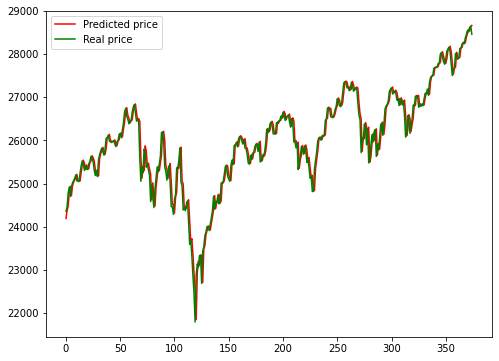

In [0]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.plot((X_test[:,-1]*(np.hstack(1+model_cnn_pct.predict(np.expand_dims(X_test_pct,2))))), color="red", label="Predicted price")
ax.plot(close_price[-375:], color="green", label="Real price")
ax.legend()

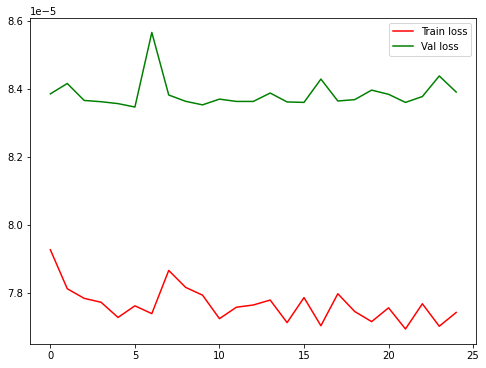

In [0]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.plot(history_cnn_pct.history['loss'], color="red", label="Train loss")
ax.plot(history_cnn_pct.history['val_loss'], color="green", label="Val loss")
ax.legend()

In [0]:
np.mean(keras.losses.mean_squared_error(X_train[:,-1]*(1+model_cnn_pct.predict(np.expand_dims(X_train_pct,2))), y_train))

19015.084

# LSTM

In [0]:
batch_size=5

In [0]:
lstm_model = keras.models.Sequential()
lstm_model.add(keras.layers.LSTM(200, batch_input_shape=(batch_size, 10,1), recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform'))
lstm_model.add(keras.layers.Dropout(0.5))
lstm_model.add(keras.layers.Dense(30,activation='relu'))
lstm_model.add(keras.layers.Dense(1,activation='linear'))

In [0]:
optimizer = keras.optimizers.Adam(lr=0.001)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)
lstm_model.compile(loss='mse', metrics=['mse'], optimizer=optimizer)

In [0]:
history_lstm = lstm_model.fit(np.expand_dims(X_train_pct[:-4],2),y_train_pct[:-4], batch_size = batch_size,
    epochs = 50, 
    verbose=1,
    validation_data=(np.expand_dims(X_test_pct,2),y_test_pct),
    shuffle=True,
    callbacks=[reduce_lr])

Train on 2125 samples, validate on 375 samples
Epoch 1/50
2125/2125 [==============================] - 7s 3ms/step - loss: 8.7106e-05 - mse: 8.7106e-05 - val_loss: 8.4863e-05 - val_mse: 8.4863e-05
Epoch 2/50
2125/2125 [==============================] - 7s 3ms/step - loss: 8.1492e-05 - mse: 8.1492e-05 - val_loss: 8.6008e-05 - val_mse: 8.6008e-05
Epoch 3/50
2125/2125 [==============================] - 7s 3ms/step - loss: 7.9863e-05 - mse: 7.9864e-05 - val_loss: 8.6743e-05 - val_mse: 8.6743e-05
Epoch 4/50
2125/2125 [==============================] - 7s 3ms/step - loss: 7.9674e-05 - mse: 7.9674e-05 - val_loss: 8.4485e-05 - val_mse: 8.4485e-05
Epoch 5/50
2125/2125 [==============================] - 7s 3ms/step - loss: 8.1540e-05 - mse: 8.1540e-05 - val_loss: 8.4527e-05 - val_mse: 8.4527e-05
Epoch 6/50
2125/2125 [==============================] - 7s 3ms/step - loss: 7.9828e-05 - mse: 7.9828e-05 - val_loss: 8.3832e-05 - val_mse: 8.3832e-05

Epoch 00006: ReduceLROnPlateau reducing learning rat

In [0]:
np.mean(keras.losses.mean_squared_error(X_train[:,-1]*(1+lstm_model.predict(np.expand_dims(X_train_pct[:-4],2),batch_size=5)), y_train))

18919.139

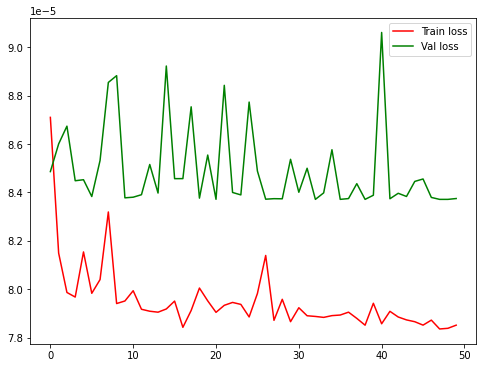

In [0]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.plot(history_lstm.history['loss'], color="red", label="Train loss")
ax.plot(history_lstm.history['val_loss'], color="green", label="Val loss")
ax.legend()

In [0]:
fig, ax = plt.subplots(1, figsize=(20, 15))
ax.plot((X[1:-4,-1]*(np.hstack(1+lstm_model.predict(np.expand_dims(X_pct[:-4],2),batch_size=5)))), color="red", label="Predicted price")
ax.plot(close_price, color="green", label="Real price")
ax.legend()

NameError: ignored